# Introduction to Quantum Machine Learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qibo.models import Circuit
from qibo import gates, hamiltonians, set_backend
from qibo.optimizers import optimize

set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-21 15:59:02]: Using numpy backend on /CPU:0


## 1. A look back to quantum circuits

In particular we will focus on parametric circuits, because we want to use them as machine learning models.

A rotational gate can be added to a `qibo` circuit using the command: `circuit.add(qibo.gates.RX(q=q, theta=theta))`,
in which you set the ID of the qubit `q` and the angle `theta`.

### Building a simple 1-qubit circuit

We start building a simple 1-qubit circuit:

In [29]:
# define a circuit
c = Circuit(1)

# we can add parametric gates
c.add(gates.RY(q=0, theta=0))
c.add(gates.RZ(q=0, theta=0))

# and a measurement gate
c.add(gates.M(0))

MeasurementResult(qubits=(0,), nshots=0)

whose information can be printed as follows:

In [30]:
# circuit drawing
print(c.draw())

# and circuit information
print(f"\n{c.summary()}")

q0: ─RY─RZ─M─

Circuit depth = 3
Total number of gates = 3
Number of qubits = 1
Most common gates:
ry: 1
rz: 1
measure: 1


We can also execute the circuit, obtaining a state, in which we collect some informations, like amplitudes and frequencies.

In [31]:
# circuit execution
final_state = c.execute(nshots=1000)
print(f"\nfinal state: {final_state}")

# print probabilities
print(f"\nprobabilities: {final_state.probabilities(qubits=[0])}")

# print frequencies
print(f"\nprobabilities: {final_state.frequencies()}")


final state: (1+0j)|0>

probabilities: [1. 0.]

probabilities: Counter({'0': 1000})


### A function for printing frequencies

In [32]:
def visualize_states(counter, ticks_rotation=0):
    """States visualization."""
 
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title('State visualization')
    ax.set_xlabel('States')
    ax.set_ylabel('#')

    for state in counter:
        ax.scatter(state, counter[state], color='purple', alpha=0.5, s=150)
        ax.vlines(state, 0, counter[state] - 12, color='black', ls='-', lw=1.2)
        
    plt.xticks(rotation=ticks_rotation)
    
    plt.grid(True)

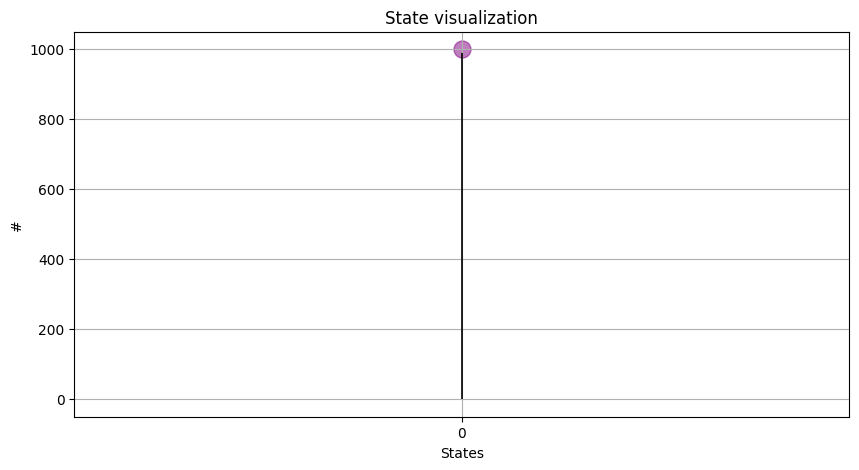

In [33]:
visualize_states(final_state.frequencies())

### Modifying circuits parameters

We can modify the circuit's parameters and have access to this information using the following commands:

- `circuit.get_parameters()` to get the parameters;
- `circuit.set_parameters(new_params)` to set `new_params` as circuit parameters.

In [34]:
# set a new angle in the RX rotation
nparams = len(c.get_parameters())
print(f"\nnparams: {nparams}")
print(f"params: {c.get_parameters()}")


nparams: 2
params: [(0,), (0,)]


In [35]:
# set a new parameter
c.set_parameters(np.random.randn(nparams))
print(f"new params: {c.get_parameters()}")

# circuit execution with new params
final_state = c.execute(nshots=1000)
print(f"\nfinal state: {final_state}")

new params: [(-0.6576918179741973,), (0.033340278473559685,)]

final state: (0.94628-0.01578j)|0> + (-0.32291-0.00538j)|1>


In [36]:
# print probabilities
print(f"\nprobabilities: {final_state.probabilities(qubits=[0])}")

# print frequencies
print(f"\nprobabilities: {final_state.frequencies()}")


probabilities: [0.89570266 0.10429734]

probabilities: Counter({'0': 893, '1': 107})


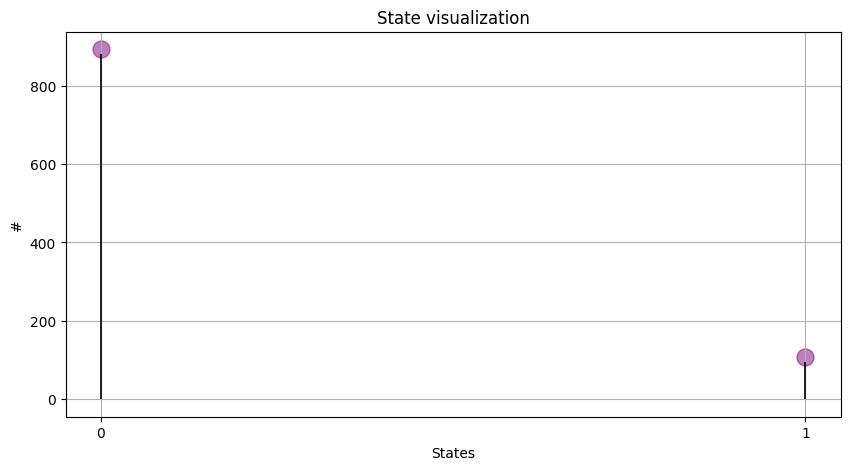

In [37]:
visualize_states(final_state.frequencies())

### Defining an Hamiltonian

We are going to define target Hamiltonians in order to use their expected value over some final state as QML predictor.
An Hamiltonian can be defined as follows with `Qibo`:

In [38]:
# set hamiltonian
h = hamiltonians.Z(nqubits=1) 
print(f"Hamiltonian:\n{h.matrix}")

# expectation
print(f"\nExpectation: {h.expectation(c.execute().state())}")

Hamiltonian:
[[-1.-0.j -0.-0.j]
 [-0.-0.j  1.-0.j]]

Expectation: -0.7914053111166367


## 2. Play with parametric gates

In [41]:
x_angles = np.linspace(-2*np.pi, 2*np.pi, 100)
y_angles = np.linspace(0, np.pi, 100)

expectations = []

for x, y in zip(x_angles, y_angles):
    c.set_parameters([x, y])
    expectations.append(h.expectation(c.execute().state()))

In [42]:
def plot_expectations(energies):
    """Plot energy in function of the epochs"""
    plt.figure(figsize=(8,5))
    plt.title("Energy over training")
    plt.plot(energies, color="purple", alpha=0.7, lw=2, label="Energy values")
    plt.xlabel(r"$\theta$")
    plt.ylabel("E")
    plt.grid(True)
    plt.legend()
    plt.show()

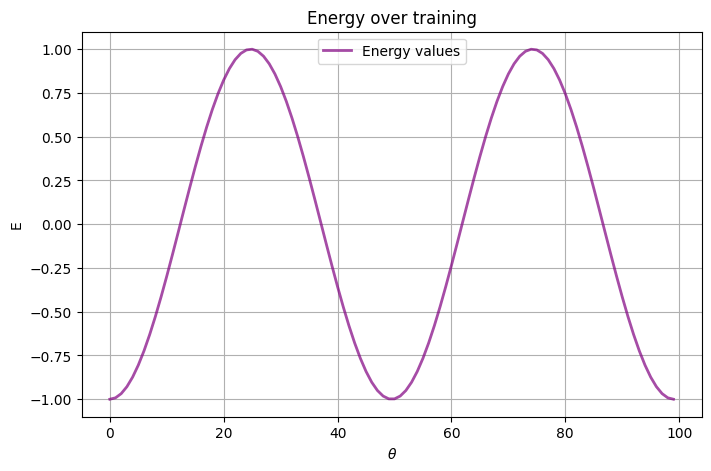

In [43]:
plot_expectations(expectations)

## 3. Injecting information into a circuit

We can define a big class of parametric circuits, which can be called Variational 
Quantum Circuits (VQC), in whose parametric gates we can inject **both** data and 
variational parameters!

<img src="figures/vqc.png" width="600" height="600" align="center"/>

One way to embed data in QML is to define some uploading layer into the circuit and then to 
repeat the uploading of the data many times [1]. 

In [45]:
# define a circuit composed of nlayers

def build_vqc(nqubits, nlayers):
    """Build VQC composed of nqubits and nlayers"""
    
    # init circuit
    vqc = Circuit(nqubits)
    
    # loop over layers
    for l in range(nlayers):
        # loop over qubits
        for q in range(nqubits):
            vqc.add(gates.RY(q=q, theta=0))
            vqc.add(gates.RY(q=q, theta=0))
            vqc.add(gates.RZ(q=q, theta=0))
            vqc.add(gates.RZ(q=q, theta=0))
        # we add an entangling channel at the end of each layer
        for q in range(0, nqubits-1):
            vqc.add(gates.CNOT(q0=q, q1=q+1))
        vqc.add(gates.CNOT(q0=nqubits-1, q1=0))
    # we add one measurement gate for each qubit
    vqc.add(gates.M(*range(nqubits)))
    
    return vqc

In the previous VQC definition, some CNOT gates are appended to the circuit. These gates are super important to create **entanglement** in the system, as you already know from the previous Quantum Computing tutorial!

In [50]:
nqubits = 4
nlayers = 2

vqc = build_vqc(nqubits=nqubits, nlayers=nlayers)
print(vqc.draw())

q0: ─RY─RY─RZ─RZ─o─────X─RY─RY─RZ─RZ─o─────X─M─
q1: ─RY─RY─RZ─RZ─X─o───|─RY─RY─RZ─RZ─X─o───|─M─
q2: ─RY─RY─RZ─RZ───X─o─|─RY─RY─RZ─RZ───X─o─|─M─
q3: ─RY─RY─RZ─RZ─────X─o─RY─RY─RZ─RZ─────X─o─M─


### Combine data and parameters while filling the circuit

In [57]:
# define a way for uploading both data and parameters

def inject_data(circuit, nlayers, parameters, x):
    """Inject data and params into the circuit."""
    
    # empty list of parameters
    params = []
    # we keep track of the index
    index = 0

    # loop over layers
    for l in range(nlayers):
        # loop over qubits
        for q in range(circuit.nqubits):
            # we fill the first RY with param * x
            params.append(parameters[index] * x)
            # bias
            params.append(parameters[index + 1])
            # we fill the first RZ with param * x
            params.append(parameters[index + 2] * x)
            # bias
            params.append(parameters[index + 3])

            # update index counter to prepare the next 4 parameters
            index += 4
    
    # set the new parameters affected by x into the circuit and return it
    circuit.set_parameters(params)
    return circuit

In [58]:
# set random parameters inside the circuit
np.random.seed(42)
old_params = np.random.randn(len(vqc.get_parameters()))
print(old_params)

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818]


In [60]:
# inject data
x = 2

vqc = inject_data(circuit=vqc, nlayers=nlayers, parameters=old_params, x=x)

# get new params after the injection
new_params = vqc.get_parameters()

# sanity check
print("Check the even params are doubled:\n")
for p in range(8):
    print(f"Old value: {old_params[p]:.4}\t New value: {new_params[p][0]:.4}")

Check the even params are doubled:

Old value: 0.4967	 New value: 0.9934
Old value: -0.1383	 New value: -0.1383
Old value: 0.6477	 New value: 1.295
Old value: 1.523	 New value: 1.523
Old value: -0.2342	 New value: -0.4683
Old value: -0.2341	 New value: -0.2341
Old value: 1.579	 New value: 3.158
Old value: 0.7674	 New value: 0.7674


### Check the final state 

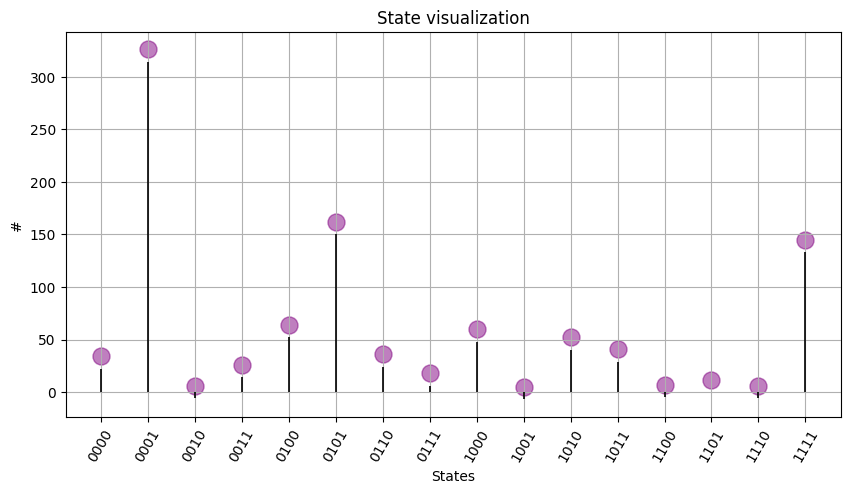

In [61]:
# final state 
fstate = vqc.execute(nshots=1000)

# frequencies
visualize_states(fstate.frequencies(), ticks_rotation=60)

## 4. A snapshot of quantum machine learning

<img src="figures/qml.png" width="1000" height="1000" align="center"/>


## 5. Exercise: tune circuit parameters to get a target value

Define:
1. a 1-qubit circuit with two parametrized gates: an RY followed by an RZ, with a measurement gate in the end;
2. an 1-qubit hamiltonian to be used as target observable: in particular I suggest you to use a pauli Z;
3. initialize the two parameters of the circuit to some value (this choice should be done in a reasonable way in principle, but in case of large circuits the parameters can also be set randomly);
4. use `qibo.optimizers.optimize` module with `method="cma"` to find the optimized params and passing as loss function the one suggested some cells below (the optimize method will return also the best set of parameters);
5. compute the expected value of the hamiltonian on the state we obtain by executing the circuit filled with the best parameters returned by the CMA optimizer;

In [65]:
# set model
model = Circuit(1)
model.add(gates.RY(q=0, theta=0))
model.add(gates.RZ(q=0, theta=0))
model.add(gates.M(0))

# set hamiltonian
hamiltonian = hamiltonians.Z(1) 

In [66]:
def mse(parameters, hamiltonian=hamiltonian, model=model, target=0.5):
    """Mean Squared Error with y_target=0.5 given model and hamiltonian."""
    expectation = hamiltonian.expectation(model.execute().state())
    return (expectation-target)**2

def loss(parameters):
    """Many optimizers need a loss function which depends only on parameters."""
    model.set_parameters(parameters)
    return mse(parameters)

In [67]:
print(model.draw())
print(hamiltonian.matrix)

q0: ─RY─RZ─M─
[[-1.-0.j -0.-0.j]
 [-0.-0.j  1.-0.j]]


In [68]:
par = np.random.randn(2)
model.set_parameters(par)

In [69]:
result = optimize(loss, par, method="cma")

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=963756, Fri Jul 21 16:24:03 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.741863962132440e-02 1.0e+00 1.85e+00  2e+00  2e+00 0:00.0
    2     12 2.461208719044788e-03 1.2e+00 1.36e+00  1e+00  1e+00 0:00.0
    3     18 7.186555853315786e-03 1.2e+00 1.55e+00  1e+00  2e+00 0:00.0
NOTE (module=cma, iteration=67):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 8.4e+07 to 1.4e+00
   80    480 2.241452665852047e-16 5.5e+00 3.40e-03  9e-08  6e-03 0:00.1
termination on tolfun=1e-11 (Fri Jul 21 16:24:03 2023)
final/bestever f-value = 3.253815e-17 5.456350e-19 after 481/342 evaluations
incumbent solution: [4.1887902113730595, 8.14119503128539]
std deviation: [8.83805370858116e-08, 0.0064759373125955685]


In [70]:
result[1]

array([4.1887902 , 8.21538426])

In [71]:
model.set_parameters(result[1])

In [72]:
hamiltonian.expectation(model.execute().state())

0.5000000007386711

## Question: can you tackle any target value using this setup?